# Model evaluation
Produce metrics and visualisations for the performance of all segementation approaches

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reload utils
import json
import importlib
from train_landsat_unet import * #load dataset and model classes

import utils
importlib.reload(utils)

import evaluation as eval
importlib.reload(eval)

<module 'evaluation' from '/Users/conorosullivan/Documents/git/COASTAL MONITORING/landsat-coastline-segmentation/src/evaluation.py'>

In [13]:
# Load test images
test_path = '../../data/LICS/test/'
test_paths = glob.glob(test_path + '*.npy')
print(len(test_paths))

test_mask = []
test_edge = []
test_cloud_mask = []

for path in test_paths:
    test = np.load(path)

    test_mask.append(test[:,:,-2])
    test_edge.append(test[:,:,-1])

    QA = test[:,:,7]
    cloud_mask = np.vectorize(utils.get_cloud_mask)(QA,type='cloud')
    test_cloud_mask.append(cloud_mask)

100


In [14]:
# Load predictions
final_preds = json.load(open('../data/predictions_update_16MAY2024.json'))
methods = ['NDWI','Canny','XGBoost','UNET','ATTUNET','R2UNET']

for method in methods:
    preds = final_preds[method]

    preds = [np.array(arr) for arr in preds]

    final_preds[method] = preds

print(final_preds.keys())

dict_keys(['NDWI', 'Canny', 'XGBoost', 'UNET', 'ATTUNET', 'R2UNET'])


In [15]:
def get_cloud_free_pixels(masks,preds,cloud_masks):
    """Return the number of cloud free pixels in the mask"""
    cloud_free_masks = []
    cloud_free_preds = []
    for i in range(len(masks)):
        cloud_mask = cloud_masks[i]

        # Make mask np.nan where there are clouds
        mask = masks[i]
        mask = mask.astype('float16')
        mask[cloud_mask==0] = np.nan

        pred = preds[i]
        pred = pred.astype('float16')
        pred[cloud_mask==0] = np.nan
        
        cloud_free_masks.append(mask)
        cloud_free_preds.append(pred)

    
    return cloud_free_masks,cloud_free_preds

In [16]:
arr_metrics = [] #metrics for each model
arr_coast_metrics = [] #within 10 pixels
arr_cloud_metrics = [] #cloud free
methods = ['NDWI','Canny','XGBoost','UNET','ATTUNET','R2UNET']

for i,method in enumerate(methods):
    preds = final_preds[method]
    metrics, arr = eval.eval_metrics(test_mask,preds)
    metrics['method'] = method

    # Get pixels close to the coast
    coast_target,coast_preds = eval.get_coastline_pixels(test_mask,preds)
    coast_metrics, coast_arr = eval.eval_metrics(coast_target,coast_preds)
    coast_metrics['method'] = method

    # Get pixels without clouds
    cloud_target,cloud_preds = get_cloud_free_pixels(test_mask,preds,test_cloud_mask)
    cloud_metrics, cloud_arr = eval.eval_metrics(cloud_target,cloud_preds)
    cloud_metrics['method'] = method

    if method == 'Canny':
        for m in ['accuracy','balanced_accuracy','precision','recall','f1']:
            metrics[m] = 0
            coast_metrics[m] = 0
            cloud_metrics[m] = 0

    arr_metrics.append(metrics)
    arr_coast_metrics.append(coast_metrics)
    arr_cloud_metrics.append(cloud_metrics)

df_metrics = pd.DataFrame(arr_metrics,columns=['method','accuracy','balanced_accuracy','precision','recall','f1','mse','fom'])
df_cmetrics = pd.DataFrame(arr_coast_metrics,columns=['method','accuracy','balanced_accuracy','precision','recall','f1','mse','fom'])
df_cloud_metrics = pd.DataFrame(arr_cloud_metrics,columns=['method','accuracy','balanced_accuracy','precision','recall','f1','mse','fom'])

/Users/conorosullivan/Documents/git/COASTAL MONITORING/landsat-coastline-segmentation/src/evaluation.py:148: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL MONITORING/landsat-coastline-segmentation/src/evaluation.py:150: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)


# Summary of metrics

In [18]:
# Evaluation metrics
df_metrics = round(df_metrics,3)
df_metrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1','MSE','FOM']
df_metrics[incl].to_clipboard(index=False)
df_metrics.head(6)

,Method,Accuracy,Balanced Accuracy,Precision,Recall,F1,MSE,FOM
0,NDWI,0.972,0.971,0.994,0.946,0.967,0.038,0.718
1,Canny,0.000,0.000,0.000,0.000,0.000,0.029,0.695
2,XGBoost,0.874,0.854,0.972,0.719,0.785,0.111,0.379
3,UNET,0.950,0.956,0.925,0.968,0.941,0.032,0.546
4,ATTUNET,0.947,0.947,0.960,0.919,0.927,0.034,0.556
5,R2UNET,0.912,0.909,0.962,0.840,0.879,0.036,0.330


In [19]:
# Evaluation metrics within 10 pixels of coastline
df_cmetrics = round(df_cmetrics,3)
df_cmetrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1']
df_cmetrics[incl].to_clipboard(index=False)
df_cmetrics.head(6)

,Method,Accuracy,Balanced Accuracy,Precision,Recall,F1,MSE,FOM
0,NDWI,0.938,0.938,0.983,0.891,0.927,0.021,0.852
1,Canny,0.000,0.000,0.000,0.000,0.000,0.027,0.728
2,XGBoost,0.786,0.789,0.939,0.614,0.697,0.047,0.624
3,UNET,0.836,0.837,0.822,0.905,0.848,0.030,0.555
4,ATTUNET,0.850,0.851,0.899,0.811,0.833,0.031,0.593
5,R2UNET,0.720,0.718,0.895,0.527,0.618,0.033,0.336


In [20]:
# Evaluation metrics with cloud free pixels
df_cloud_metrics = round(df_cloud_metrics,3)
df_cloud_metrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1']
df_cloud_metrics[incl].to_clipboard(index=False)
df_cloud_metrics[incl].head(6)

,Method,Accuracy,Precision,Recall,F1
0,NDWI,0.978,0.994,0.958,0.974
1,Canny,0.000,0.000,0.000,0.000
2,XGBoost,0.878,0.974,0.727,0.790
3,UNET,0.953,0.927,0.972,0.944
4,ATTUNET,0.950,0.961,0.924,0.930
5,R2UNET,0.914,0.964,0.843,0.881


# Display predictions

In [21]:
def calc_accuracy(mask,pred):  
    """Calculate accuracy of a prediction"""

    mask = np.array(mask)
    pred = np.array(pred)

    mask = mask.flatten()
    pred = pred.flatten()

    acc = np.sum(mask == pred) / len(mask)

    return acc

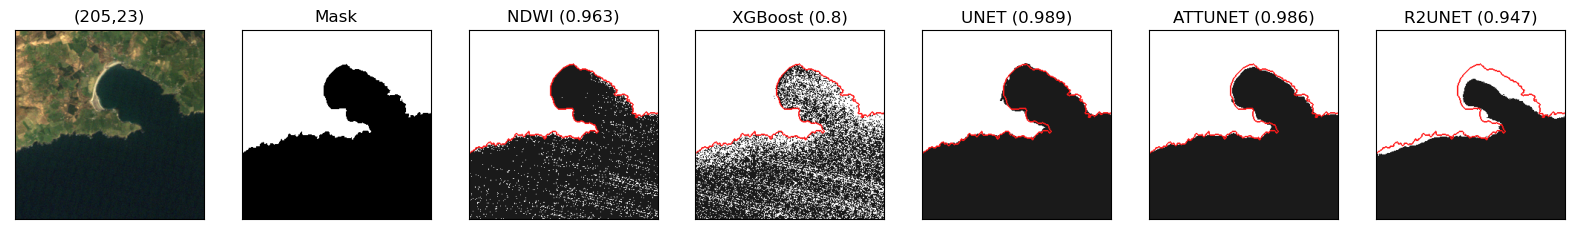

In [22]:


def plot_predicted_masks(i,methods = ['NDWI','XGBoost','UNET','ATTUNET','R2UNET'],tile=None):

    path = test_paths[i]
    test = np.load(path)
    rgb = utils.rgb_from_stack(test)

    mask = test[:,:,-2]
    edge = utils.edge_from_mask(mask)

    #only show edge in pixel value is 1
    edge = edge.astype(np.float64)
    edge[edge==0] = np.nan

    # make edge 3D
    edge = np.repeat(edge[:,:,np.newaxis],3,axis=2)

    fig,ax = plt.subplots(1,2+len(methods),figsize=(20,5))

    ax[0].imshow(rgb)
    path = tile.split('_')[0]
    row = tile.split('_')[1]
    ax[0].title.set_text(f"({path},{row})")

    ax[1].imshow(1-mask,cmap='gray')
    ax[1].set_title("Mask")

    for j, method in enumerate(methods):
        edge_j = edge.copy()

        pred = final_preds[method][i]
        accuracy = calc_accuracy(mask,pred)

        pred = 1-pred
        pred = pred.astype(np.float64)
        pred = np.repeat(pred[:,:,np.newaxis],3,axis=2)

        pred = np.where(np.isnan(edge_j),pred,[1,0,0])
    
        ax[j+2].imshow(pred,alpha=0.9)

        accuracy = round(accuracy,3)
        ax[j+2].set_title(f"{method} ({accuracy})")

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    return fig

fig = plot_predicted_masks(0,methods = ['NDWI','XGBoost','UNET','ATTUNET','R2UNET'],tile="205_23")

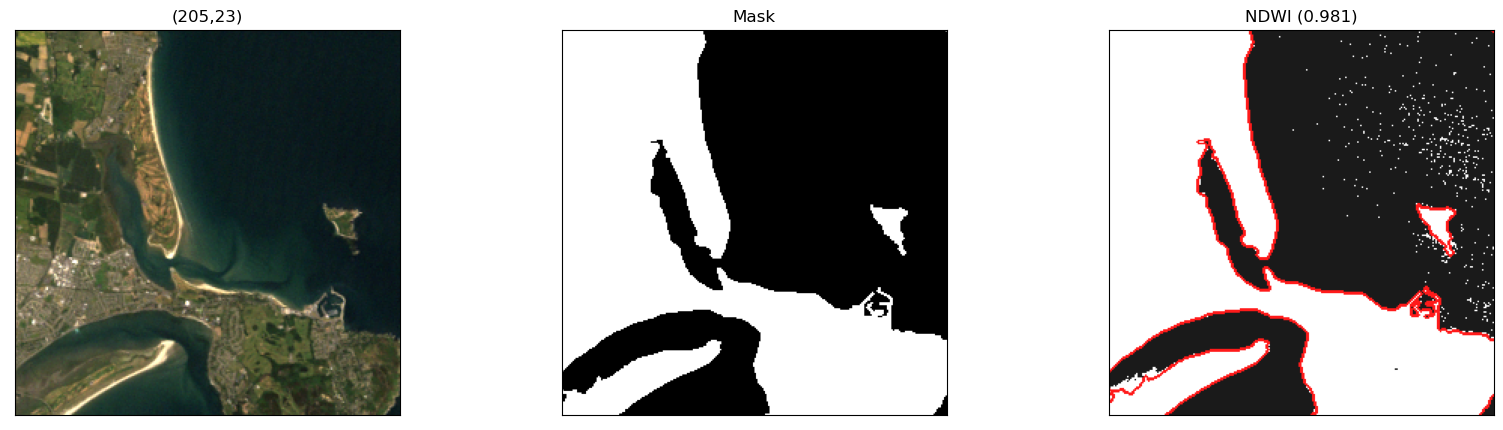

In [23]:
fig = plot_predicted_masks(3,methods = ['NDWI'],tile="205_23")

In [25]:
df_labels = pd.read_csv('../data/label_scenes.csv')
df_labels.columns = ['year', 'altitude_category', 'id', 'path', 'row', 'satellite',
       'cloud_cover', 'tier', 'utm_zone', 'lat', 'lon', 'date', 'time',
       'month', 'altitude', 'tile']

df_labels.head()

,year,altitude_category,id,path,row,satellite,cloud_cover,tier,utm_zone,lat,lon,date,time,month,altitude,tile
0,2017,high,LC08_L2SP_205023_20170505_20200904_02_T1,205,23,8,2,1,30,53.10266,-5.02235,2017-05-05,2017-05-05 11:15:45.516137,5,51.383728,205_23
1,2019,high,LC08_L2SP_205023_20190628_20200827_02_T1,205,23,8,9,1,30,53.10258,-5.04996,2019-06-28,2019-06-28 11:16:20.726652,6,57.582579,205_23
2,2020,high,LC08_L2SP_205023_20200529_20200820_02_T1,205,23,8,2,1,30,53.10270,-5.03278,2020-05-29,2020-05-29 11:15:55.184734,5,56.487645,205_23
3,2015,low,LC08_L2SP_205024_20150124_20200910_02_T1,205,24,8,4,1,30,51.69320,-5.72348,2015-01-24,2015-01-24 11:16:47.907172,1,17.108840,205_24
4,2015,high,LC08_L2SP_205024_20150719_20200909_02_T1,205,24,8,5,1,30,51.69345,-5.70362,2015-07-19,2015-07-19 11:16:25.474865,7,56.077386,205_24


In [26]:
# create lists of ids for all unique tile values
def get_grouped_ids(df,cat='tile'):
    unique_cat = df[cat].unique()
    ids = {}

    for c in unique_cat:
        ids[c] = df_labels[df_labels[cat] == c]['id'].values

    return ids

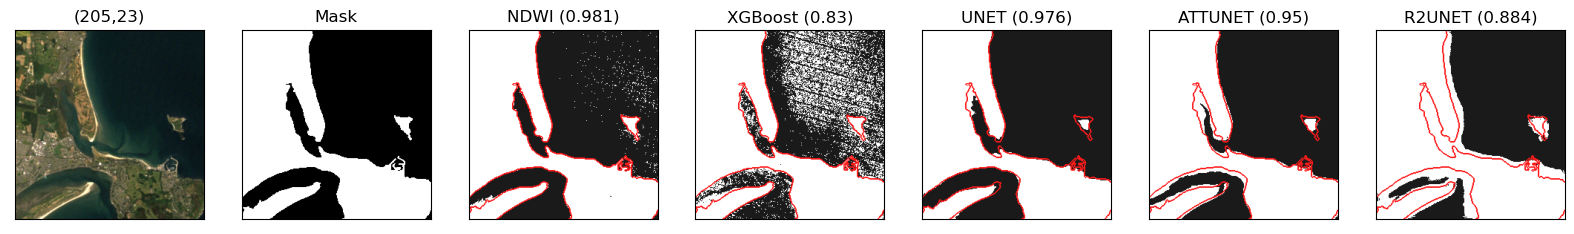

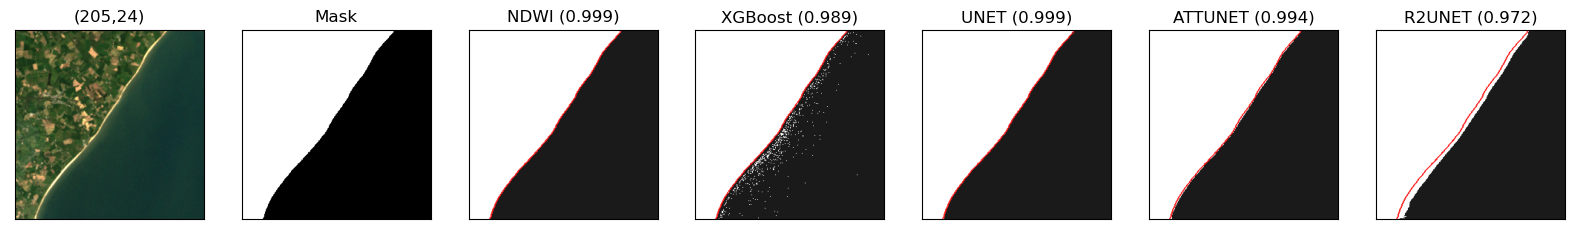

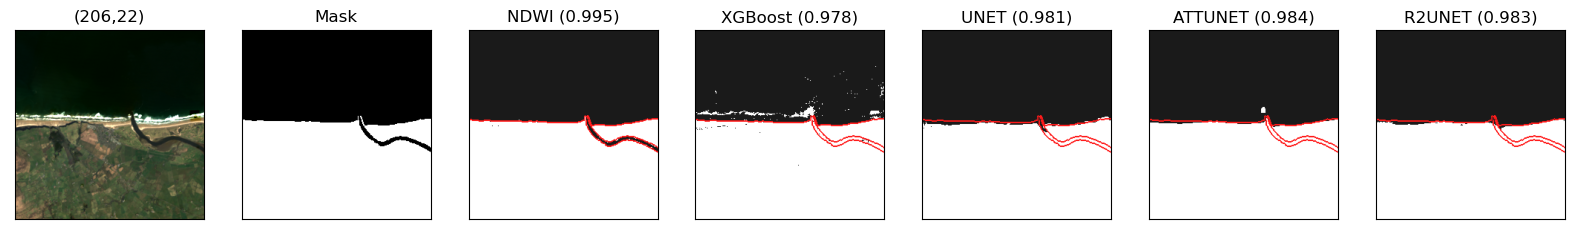

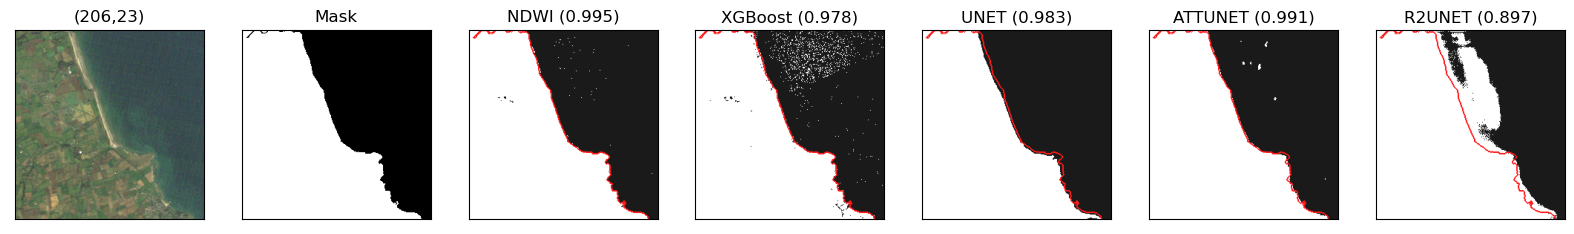

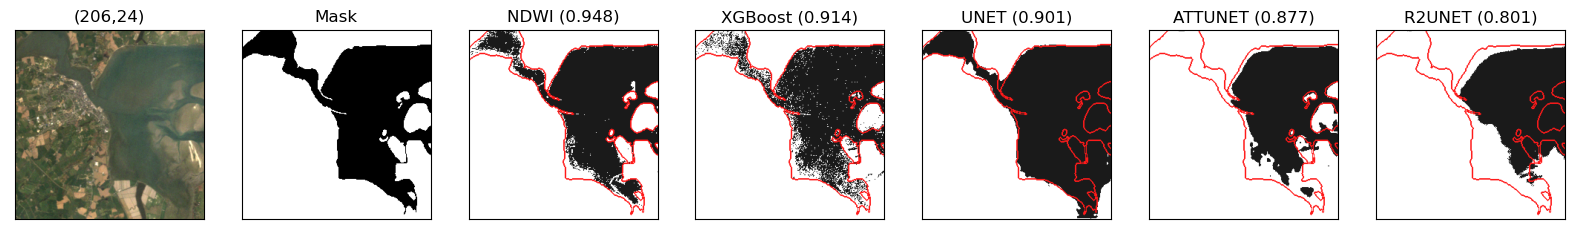

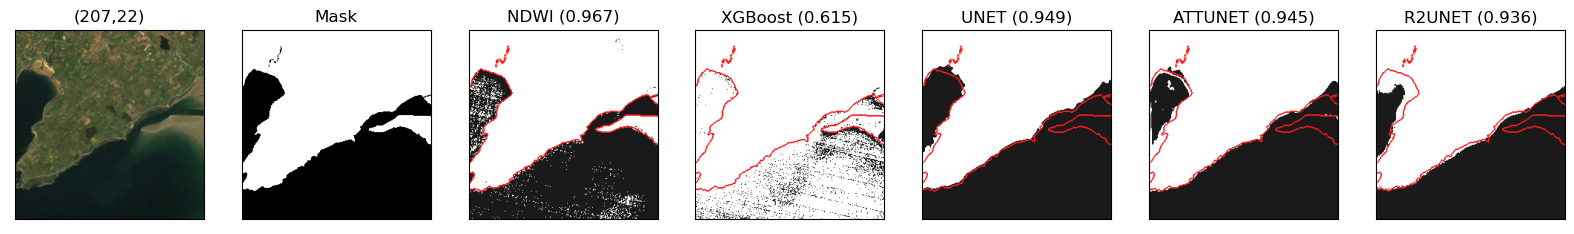

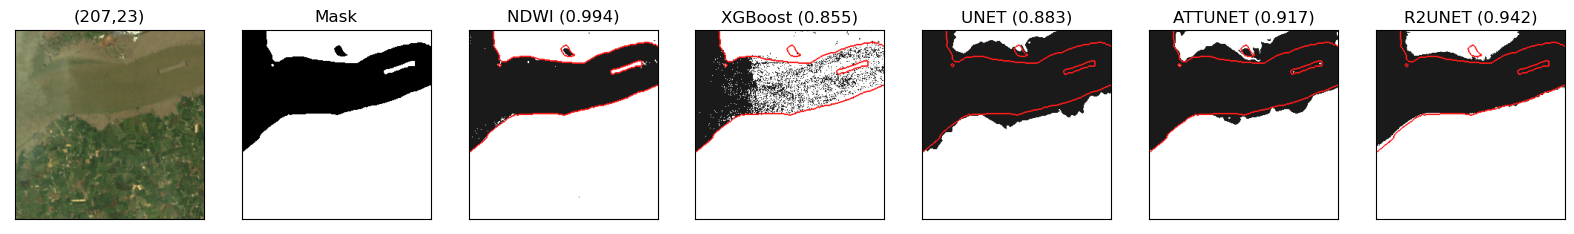

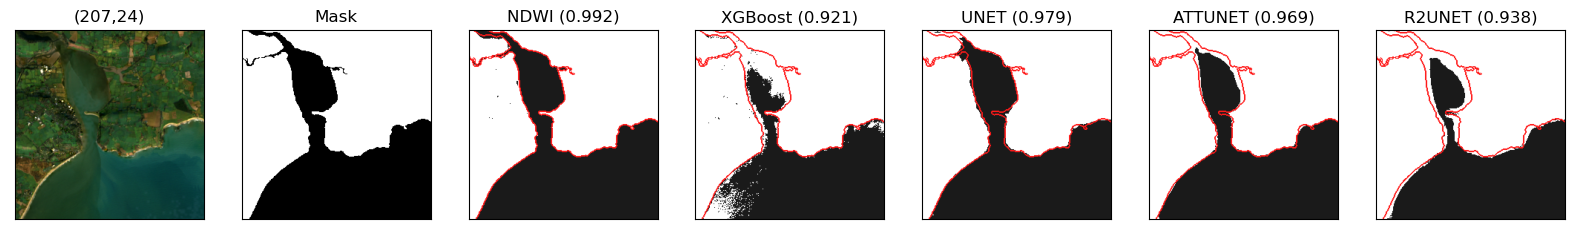

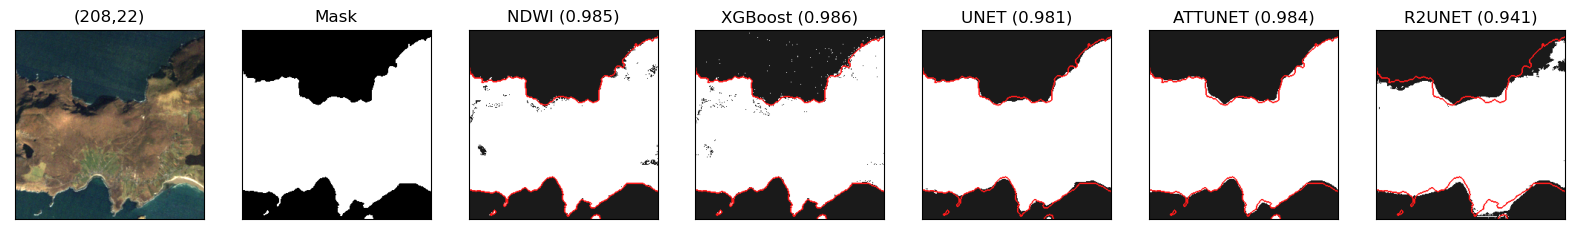

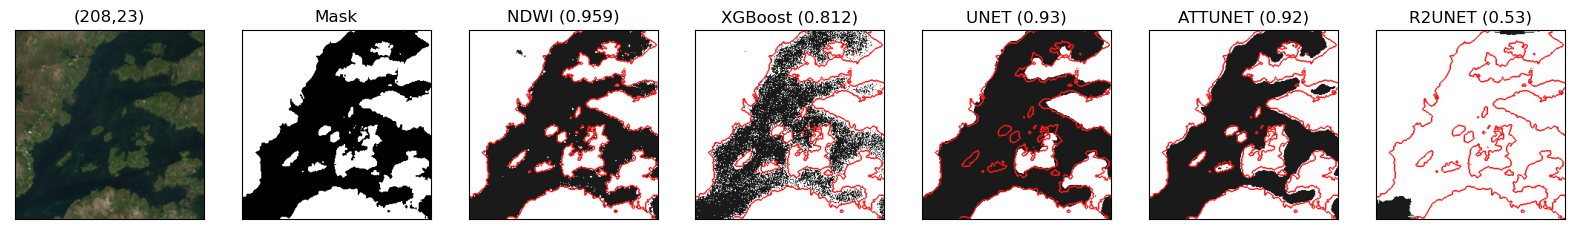

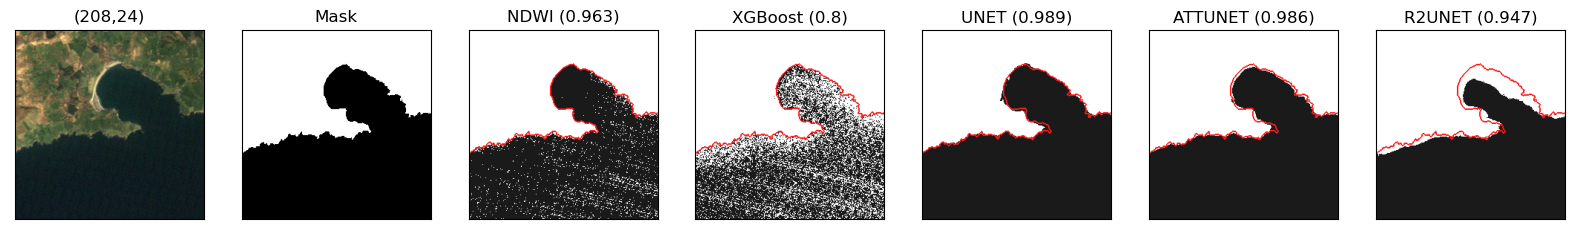

In [29]:
tile_ids = get_grouped_ids(df_labels,cat='tile')

tiles = ['205_23','205_24','206_22','206_23','206_24','207_22','207_23','207_24','208_22','208_23','208_24']

chosen_ids = []
for tile in tiles:
    ids = tile_ids[tile]
    id = random.choice(ids)
    chosen_ids.append(id)

for id,tile in zip(chosen_ids, tiles):
    i = test_paths.index(test_path + id + '.npy')
    fig = plot_predicted_masks(i,methods = ['NDWI','XGBoost','UNET','ATTUNET','R2UNET'],tile=tile)
    utils.save_fig(fig,f'{tile}_masks')

# Accuracy by year 

In [30]:
df_labels['decade'] = df_labels['year'].apply(lambda x: int(x/10)*10)

df_labels.head()

,year,altitude_category,id,path,row,satellite,cloud_cover,tier,utm_zone,lat,lon,date,time,month,altitude,tile,decade
0,2017,high,LC08_L2SP_205023_20170505_20200904_02_T1,205,23,8,2,1,30,53.10266,-5.02235,2017-05-05,2017-05-05 11:15:45.516137,5,51.383728,205_23,2010
1,2019,high,LC08_L2SP_205023_20190628_20200827_02_T1,205,23,8,9,1,30,53.10258,-5.04996,2019-06-28,2019-06-28 11:16:20.726652,6,57.582579,205_23,2010
2,2020,high,LC08_L2SP_205023_20200529_20200820_02_T1,205,23,8,2,1,30,53.10270,-5.03278,2020-05-29,2020-05-29 11:15:55.184734,5,56.487645,205_23,2020
3,2015,low,LC08_L2SP_205024_20150124_20200910_02_T1,205,24,8,4,1,30,51.69320,-5.72348,2015-01-24,2015-01-24 11:16:47.907172,1,17.108840,205_24,2010
4,2015,high,LC08_L2SP_205024_20150719_20200909_02_T1,205,24,8,5,1,30,51.69345,-5.70362,2015-07-19,2015-07-19 11:16:25.474865,7,56.077386,205_24,2010


In [31]:
decade_ids = get_grouped_ids(df_labels,cat='decade')

decades = [1980,1990,2000,2010,2020]
decade_acc = {}

preds_ndwi = final_preds['NDWI']
preds_unet = final_preds['UNET']

for decade in decades:
    ids = decade_ids[decade]
    idxs = [test_paths.index(test_path + id + '.npy') for id in ids]

    test_mask_alt = [test_mask[i] for i in idxs]
    preds_ndwi_alt = [preds_ndwi[i] for i in idxs]
    preds_unet_alt = [preds_unet[i] for i in idxs] 

    metrics_ndwi, arr_ndwi = eval.eval_metrics(test_mask_alt,preds_ndwi_alt)
    metrics_unet, arr_unet = eval.eval_metrics(test_mask_alt,preds_unet_alt)

    acc_ndwi = np.round(metrics_ndwi['accuracy'],3)
    acc_unet = np.round(metrics_unet['accuracy'],3)

    decade_acc[decade] = [acc_ndwi,acc_unet]
    
df_decade_acc = pd.DataFrame(decade_acc,index=['NDWI','UNET'])
df_decade_acc = df_decade_acc.T

df_decade_acc['n'] = [len(decade_ids[decade]) for decade in decades]
df_decade_acc[['n','NDWI','UNET']]

,n,NDWI,UNET
1980,15,0.985,0.951
1990,27,0.961,0.951
2000,24,0.971,0.946
2010,23,0.969,0.960
2020,11,0.989,0.937


In [32]:
# count the number of tiles per decade
df = df_labels.copy()
df['tile'] = [f'({tile.split("_")[0]},{tile.split("_")[1]})' for tile in df['tile']]
df = df[['decade','tile']].groupby(['decade','tile']).size()
df.to_clipboard()
df.head()

decade  tile    
1980    (205,23)    1
        (205,24)    2
        (206,22)    1
        (206,23)    2
        (206,24)    1
dtype: int64

# Accuracy by altitude

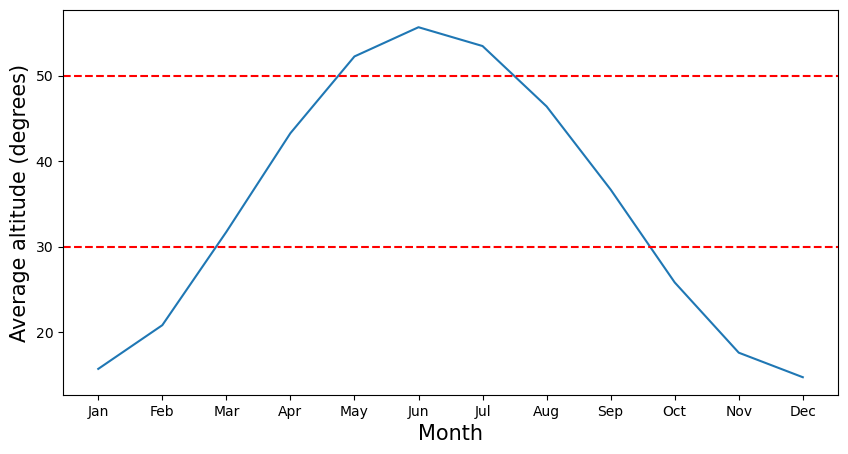

In [33]:
df_scenes = pd.read_csv('../data/all_scenes_cleaned.csv')

# altitude sense check
fig, ax = plt.subplots(1,1,figsize=(10, 5))

avg_altitude = df_scenes.groupby('month')['altitude'].mean()

# plot line chart of average altitude by month
sns.lineplot(data=avg_altitude, ax=ax)

# add red horizontal line at 30 degrees
ax.axhline(y=30, color='r', linestyle='--')
ax.axhline(y=50, color='r', linestyle='--')

# set ticks and labels
ax.set_xticks(range(1,13))
ax.set_xlabel('Month',size=15)
ax.set_ylabel('Average altitude (degrees)',size=15)

# set x tick labels to month names
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

utils.save_fig(fig,'Altitude')

In [34]:
altitude_ids = get_grouped_ids(df_labels,cat='altitude_category')

altitudes = ['low','medium','high']
altitude_acc = {}

preds_ndwi = final_preds['NDWI']
preds_unet = final_preds['UNET']

for altitude in altitudes:
    ids = altitude_ids[altitude]
    idxs = [test_paths.index(test_path + id + '.npy') for id in ids]

    test_mask_alt = [test_mask[i] for i in idxs]
    preds_ndwi_alt = [preds_ndwi[i] for i in idxs]
    preds_unet_alt = [preds_unet[i] for i in idxs] 

    metrics_ndwi, arr_ndwi = eval.eval_metrics(test_mask_alt,preds_ndwi_alt)
    metrics_unet, arr_unet = eval.eval_metrics(test_mask_alt,preds_unet_alt)

    acc_ndwi = np.round(metrics_ndwi['accuracy'],3)
    acc_unet = np.round(metrics_unet['accuracy'],3)

    altitude_acc[altitude] = [acc_ndwi,acc_unet]
    
df_altitude_acc = pd.DataFrame(altitude_acc,index=['NDWI','UNET'])
df_altitude_acc = df_altitude_acc.T

In [35]:
df_altitude_acc['n'] = [len(altitude_ids[altitude]) for altitude in altitudes]
df_altitude_acc[['n','NDWI','UNET']]

,n,NDWI,UNET
low,34,0.984,0.951
medium,34,0.963,0.943
high,32,0.969,0.958


# Accuracy by tile 

In [36]:
tile_ids = get_grouped_ids(df_labels,cat='tile')

tiles = ['205_23','205_24','206_22','206_23','206_24','207_22','207_23','207_24','208_22','208_23','208_24']
tile_acc = {}

preds_ndwi = final_preds['NDWI']
preds_unet = final_preds['UNET']

for tile in tiles:
    ids = tile_ids[tile]
    idxs = [test_paths.index(test_path + id + '.npy') for id in ids]

    test_mask_tile = [test_mask[i] for i in idxs]
    preds_ndwi_tile = [preds_ndwi[i] for i in idxs]
    preds_unet_tile = [preds_unet[i] for i in idxs]

    metrics_ndwi, arr_ndwi = eval.eval_metrics(test_mask_tile,preds_ndwi_tile)
    metrics_unet, arr_unet = eval.eval_metrics(test_mask_tile,preds_unet_tile)

    acc_ndwi = np.round(metrics_ndwi['accuracy'],3)
    acc_unet = np.round(metrics_unet['accuracy'],3)

    tile_acc[tile] = [acc_ndwi,acc_unet]

df_tile_acc = pd.DataFrame(tile_acc,index=['NDWI','UNET'])
df_tile_acc = df_tile_acc.T

df_tile_acc['n'] = [len(tile_ids[tile]) for tile in tiles]

df_tile_acc.index = [f'({tile.split("_")[0]},{tile.split("_")[1]})' for tile in tiles]

df_tile_acc[['n','NDWI','UNET']]

,n,NDWI,UNET
"(205,23)",11,0.990,0.930
"(205,24)",20,0.966,0.985
"(206,22)",9,0.982,0.978
"(206,23)",6,0.996,0.982
"(206,24)",10,0.976,0.920
"(207,22)",9,0.934,0.966
"(207,23)",10,0.991,0.876
"(207,24)",7,0.994,0.964
"(208,22)",6,0.959,0.980
"(208,23)",6,0.955,0.866


# Metrics without clouds 

0.056228956228956226


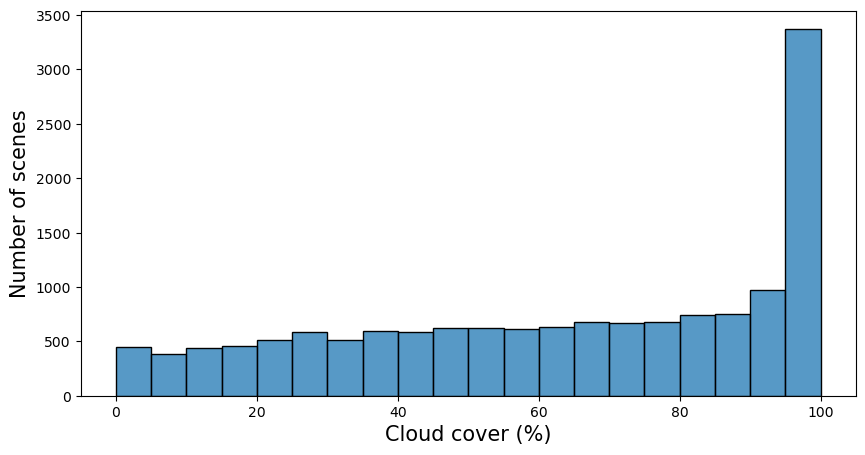

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

# Histogram of cloud cover
sns.histplot(data=df_scenes, x='cloud_cover', bins=20)
plt.xlabel('Cloud cover (%)', fontsize=15)
plt.ylabel('Number of scenes', fontsize=15)

# Percentage of cloud cover below 10%
print(len(df_scenes[df_scenes['cloud_cover'] < 10]) / len(df_scenes))

utils.save_fig(fig, 'cloud_cover_hist')


9


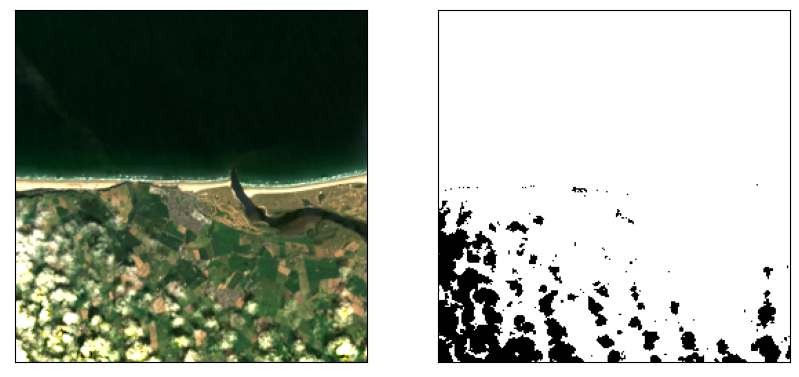

In [39]:
def plot_cloud_mask(i):

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    
    path = test_paths[i]
    test = np.load(path)

    rgb = utils.rgb_from_stack(test)
    ax[0].imshow(rgb)

    rgb = rgb*test_cloud_mask[i][:,:,np.newaxis]

    ax[1].imshow(test_cloud_mask[i],cmap='gray')

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
   
i = np.random.randint(0,len(test_paths))
print(i)
plot_cloud_mask(i)

In [40]:
# Evaluation metrics with cloud free pixels
df_cloud_metrics = round(df_cloud_metrics,3)
df_cloud_metrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1']
df_cloud_metrics[incl].to_clipboard(index=False)
df_cloud_metrics[incl].head(6)

,Method,Accuracy,Precision,Recall,F1
0,NDWI,0.978,0.994,0.958,0.974
1,Canny,0.000,0.000,0.000,0.000
2,XGBoost,0.878,0.974,0.727,0.790
3,UNET,0.953,0.927,0.972,0.944
4,ATTUNET,0.950,0.961,0.924,0.930
5,R2UNET,0.914,0.964,0.843,0.881


## Purmutation Band Importance

In [53]:

import network 
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# set variables for evaluation
target_pos = 9
incl_bands = [0,1,2,3,4,5,6]

model = network.U_Net(7,2).to(device)

# Load saved model 
state_dict = torch.load(f'../../models/LANDSAT-UNET-12MAY24.pth', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [64]:
band_dict = {'Blue':0,'Green':1,'Red':2,'NIR':3,'SWIR 1':4,'SWIR 2':5,'thermal':6}

oringal_bands = ['Blue','Green','Red','NIR','SWIR 1','SWIR 2','thermal']
#oringal_bands = ['Blue','NIR']

perm_bands = []
for band in oringal_bands:
    perm_bands.append([band])

# Calculate permutation importance
n = 5
rows = []

targets, preds = eval.get_preds(model,test_paths,target_pos=target_pos,incl_bands=incl_bands,batch_size=10,perm_bands=None)
accuracy = eval.calc_accuracy(test_mask,preds)
rows.append([str([]),0,accuracy])

for bands in perm_bands:
    print(bands,end=" ")
    for i in range(n):
        targets, preds = eval.get_preds(model,test_paths,target_pos=target_pos,incl_bands=incl_bands, perm_bands=bands)
        accuracy = eval.calc_accuracy(test_mask,preds)
        row = [str(bands),i,accuracy] 
        rows.append(row)

        print(i,end=" ")

    print()
    
df_metrics = pd.DataFrame(rows,columns = ['Bands',"Perm","Accuracy"])
df_metrics.to_csv('../data/perm_metrics_16MAY24.csv',index=False)
df_metrics.head()

['Blue'] 0 1 2 3 4 
['Green'] 0 1 2 3 4 
['Red'] 0 1 2 3 4 
['NIR'] 0 1 2 3 4 
['SWIR 1'] 0 1 2 3 4 
['SWIR 2'] 0 1 2 3 4 
['thermal'] 0 1 2 3 4 


,Bands,Perm,Accuracy
0,[],0,0.950345
1,['Blue'],0,0.948779
2,['Blue'],1,0.948835
3,['Blue'],2,0.948866
4,['Blue'],3,0.948797


Blue 0.15
Green 0.12
Red -0.0
NIR 38.96
SWIR 1 17.17
SWIR 2 -0.03
thermal -0.17


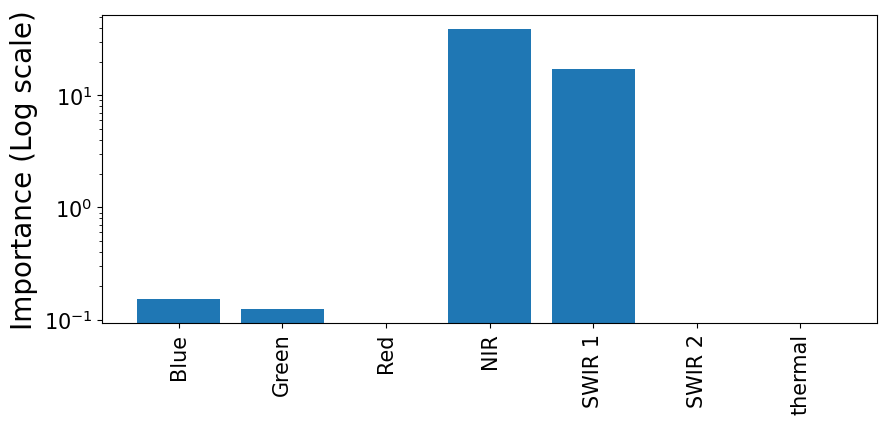

In [65]:
df_metrics = pd.read_csv('../data/perm_metrics_16MAY24.csv')
mean = df_metrics[['Bands','Accuracy']].groupby(["Bands"], sort=False ).mean().reset_index()

orginal_accuracy = mean['Accuracy'].values[0]
bands = mean['Accuracy'].values[1:8]
importance = [(orginal_accuracy-b)*100 for b in bands]

for i,imp in enumerate(importance):
    print(oringal_bands[i],np.round(imp,2))

eval.plot_importance(importance,oringal_bands,label="Importance (Log scale)",save="Perm_importance")

# Archive

In [ ]:
def plot_predicted_edge(i,methods = ['NDWI','Canny','UNET'],tile=None):
    
    path = test_paths[i]
    test = np.load(path)
    rgb = utils.rgb_from_stack(test)

    mask = test[:,:,-2]
    test_edge = utils.edge_from_mask(mask)

    #only show edge in pixel value is 1
    edge = test_edge.astype(np.float64)
    edge[edge==0] = np.nan

    # make edge 3D
    zeros = np.zeros((edge.shape[0],edge.shape[1],3))
    zeros = 1 + zeros
    edge = np.repeat(edge[:,:,np.newaxis],3,axis=2)
    edge_mask = np.where(np.isnan(edge),zeros,[1,0,0])

    fig,ax = plt.subplots(1,4,figsize=(16,5))

    ax[0].imshow(rgb)
    path = tile.split('_')[0]
    row = tile.split('_')[1]
    ax[0].title.set_text(f"({path},{row})")

    methods = ['NDWI','Canny','UNET']

    for j, method in enumerate(methods):

        edge_mask_j = edge_mask.copy()
        
        colour = [1,0,1] #purple
        if method == 'Canny':
            colour = [0,1,0] #green
        elif method == 'UNET':
            colour = [0,0,1] #blue

        mask = final_preds[method][i]

        edge = utils.edge_from_mask(mask)

        fom = eval.calc_fom(test_edge,edge)

        edge = edge.astype(np.float64)
        edge[edge==0] = np.nan
        edge = np.repeat(edge[:,:,np.newaxis],3,axis=2)

        #add alpha channel
        edge_mask_j = np.where(np.isnan(edge),edge_mask_j,[0,0,1])

        ax[j+1].imshow(edge_mask_j)
        fom = round(fom,3)
        ax[j+1].set_title(f"{method} ({fom})")

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
    return fig

fig = plot_predicted_edge(0,methods = ['NDWI','Canny','UNET'],tile="205_23")

for id,tile in zip(chosen_ids, tiles):
    i = test_paths.index(test_path + id + '.npy')
    #plot_predicted_masks(i,methods = ['NDWI','XGBoost','UNET'])
    fig = plot_predicted_edge(i,methods = ['NDWI','Canny','UNET'],tile=tile)

    utils.save_fig(fig,f'{tile}_edge')